## Installing and upgrading libraries

!pip install -q datascience                   
!pip install -U ydata-profiling
!pip install xgboost
!pip install pyodbc
!pip install Pillow
!pip install --upgrade pip
!pip install --upgrade Pillow --user
!pip install imblearn
!pip install graphviz

## Importing libraries

In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance, to_graphviz
from sklearn.metrics import classification_report
from yellowbrick.classifier import PrecisionRecallCurve

from ydata_profiling import ProfileReport

from imblearn.over_sampling import SMOTE

## Data features

We have extracted **data for financial transactions** and the link can be retrieved from the attached <a href = "https://storage.googleapis.com/industryanalytics/trans_fraud_data.csv">link</a>.

| Records | Features | Dataset Size |
| :-- | :-- | :-- |
| 6,362,620 | 10 | 457 MB| 

| Id | Features | Description |
| :-- | :--| :--| 
|01| **step** | Unit time in real world. Example one hour = one step, Max step is 743 = 31 days|
|02| **trans_type** | Transaction Type (CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER) |
|03| **trans_amount** | Amount of the transaction in local currency |
|04| **sender_name** | Person who initiated the transaction |
|05| **sender_old_bal** | Initial balance before transaction |
|06| **sender_new_bal** | New balance after transaction |
|07| **receiver** | Person who received the transaction |
|08| **receiver_old_bal** | Recipient's initial balance before transaction. Note that there is no information for customers that start with M (Merchants) i.e receiver_old_bal = 0. |
|09| **receiver_new_bal** | Recipient's new balance after transaction. Note that there is no information for customers that start with M (Merchants) i.e receiver_new_bal = 0. |
|10| **check_fraud** | This is the transactions made by the fraudulent agents. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts.|
|| |Then try to empty the funds by transferring to another account and then cashing out of the system. Transacted amount greater than 200,000 has been considered as fraudulent.|

## Data Loading

In [2]:
data=pd.read_csv("https://storage.googleapis.com/industryanalytics/trans_fraud_data.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(data.shape)
data.head()

(6362620, 10)


,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Preliminary Data understanding

In [3]:
data.trans_type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: trans_type, dtype: int64

In [4]:
data.describe()

,step,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,check_fraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


**Observation:**


  - **25% of data is zero** for sender_old_bal, receiver_old_bal & receiver_new_bal.
  - **50% of data is zero** for sender_new_bal.
  - On **average, transaction amount** of **~$\$$179861.9 dollars** have been seen moving to and fro **over** the **accumulated data**.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   trans_type        object 
 2   trans_amount      float64
 3   sender_name       object 
 4   sender_old_bal    float64
 5   sender_new_bal    float64
 6   receiver          object 
 7   receiver_old_bal  float64
 8   receiver_new_bal  float64
 9   check_fraud       int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


## Pre-Profiling Report

profile = ProfileReport(df=data, minimal=True)
profile.to_file("PreProfilingReport.html")

**Observation:**

- There are 6 numerical, 3 categorical and 1 bool features.
- There were **no missing cells**.
- There were **no duplicate rows**.
- **trans_amount** is highly skewed
- **sender_old_bal** is found to **have 33% of zeros** and **sender_new_bal 56.7% of zeros**.
- **receiver_old_bal** is found to **have 42.5% of zeros** and **receiver_new_bal 38.3% of zeros**.
- **trans_type** feature **poorly represented**, and makes up only 0.7% of whole data.
- **check_fraud** feature is **poorly represented**, and makes up only 0.1% of whole data.

## Data Pre-Processing

### Missing values

In [6]:
null_frame = pd.DataFrame(data.isnull().sum(), columns=['Frequency'])
null_frame.T

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
Frequency,0,0,0,0,0,0,0,0,0,0


**Observation:**

- no missing values in dataset

### Numerical Data Distribution

In [7]:
num_features=[]

for i in data.columns:
    if ((data[i].dtype=='int64') | (data[i].dtype==float)):
        num_features.append(i)
print(num_features)
print("number of numeric featurs: ",len(num_features))

['step', 'trans_amount', 'sender_old_bal', 'sender_new_bal', 'receiver_old_bal', 'receiver_new_bal', 'check_fraud']
number of numeric featurs:  7


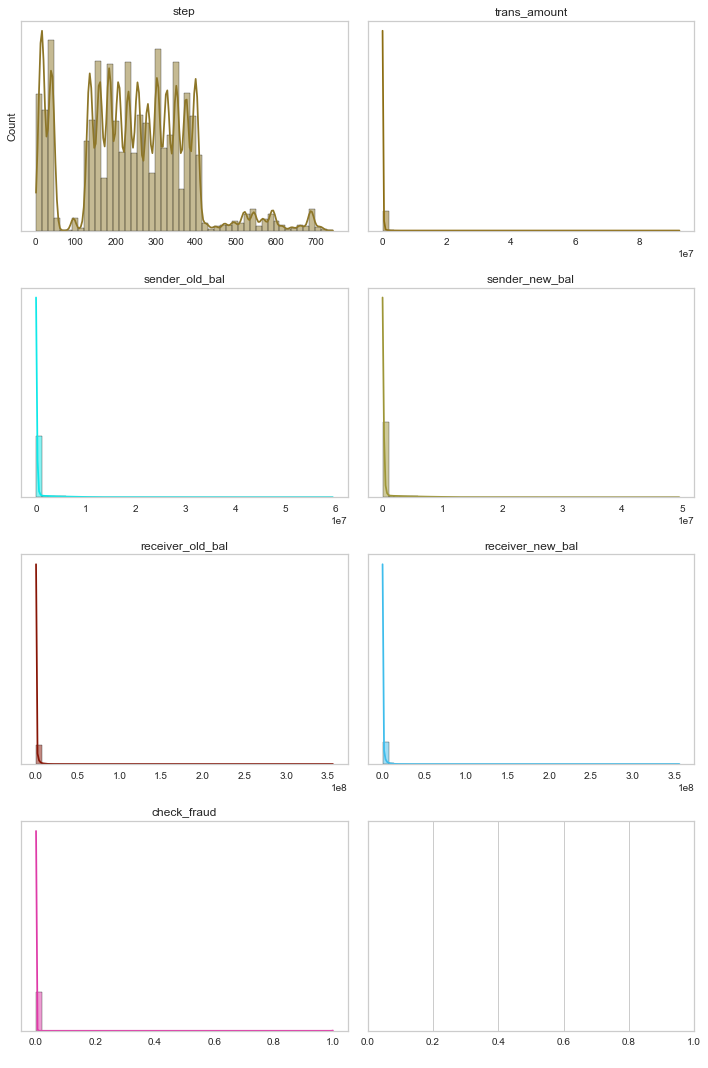

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, figsize=(10,15))

colors = []
for i in range(7):
  colors.append('#%06X' % randint(0, 0xFFFFFF))

for ax, col, color in zip(axes.flat, num_features, colors):
    sns.histplot(data=data, x=col, bins=50, ax=ax, kde=True, color=color)
    ax.set_title(col)
    plt.setp(axes, yticks=[])
    ax.set_xlabel(' ')
    ax.grid(False)
plt.tight_layout()
plt.show()

**Observation:**
- All **numerical features are found to positively skewed except step feature**.
- **step** feature **contains random distribution** of data.

### Duplicate rows

In [9]:
print("Number of duplicate rows? ", data.duplicated().sum())

Number of duplicate rows?  0


**Observation:**

- **no duplicate rows present**.

### Duplicate columns

In [10]:
equal_cols=[]
for i in range(len(data.columns)):
    col1=data.iloc[:,i]
    for j in range(i+1,len(data.columns)):
        col2=data.iloc[:,j]
        if col1.equals(col2):
            equal_cols.append({data.columns[i]:data.columns[j]})

print("Duplicated columns are:", equal_cols if len(equal_cols)>0 else None)

Duplicated columns are: None


### Handling Inconsistent Data types

In [11]:
data.dtypes

step                  int64
trans_type           object
trans_amount        float64
sender_name          object
sender_old_bal      float64
sender_new_bal      float64
receiver             object
receiver_old_bal    float64
receiver_new_bal    float64
check_fraud           int64
dtype: object

**Observation**

- check_fraud should be converted from **int64** to **boolean**

In [12]:
data.check_fraud = data.check_fraud.astype(bool)
data.dtypes

step                  int64
trans_type           object
trans_amount        float64
sender_name          object
sender_old_bal      float64
sender_new_bal      float64
receiver             object
receiver_old_bal    float64
receiver_new_bal    float64
check_fraud            bool
dtype: object

In [13]:
data.head()

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False


## Pre-EDA

### General Transaction Analysis

**Question 1:** what is the **frequency and proportion** of each **transaction type** that has occurred?

In [14]:
trans_type_frame = pd.DataFrame(data.trans_type.value_counts())
trans_type_frame.columns=['Frequency']
trans_type_frame.T

,CASH_OUT,PAYMENT,CASH_IN,TRANSFER,DEBIT
Frequency,2237500,2151495,1399284,532909,41432


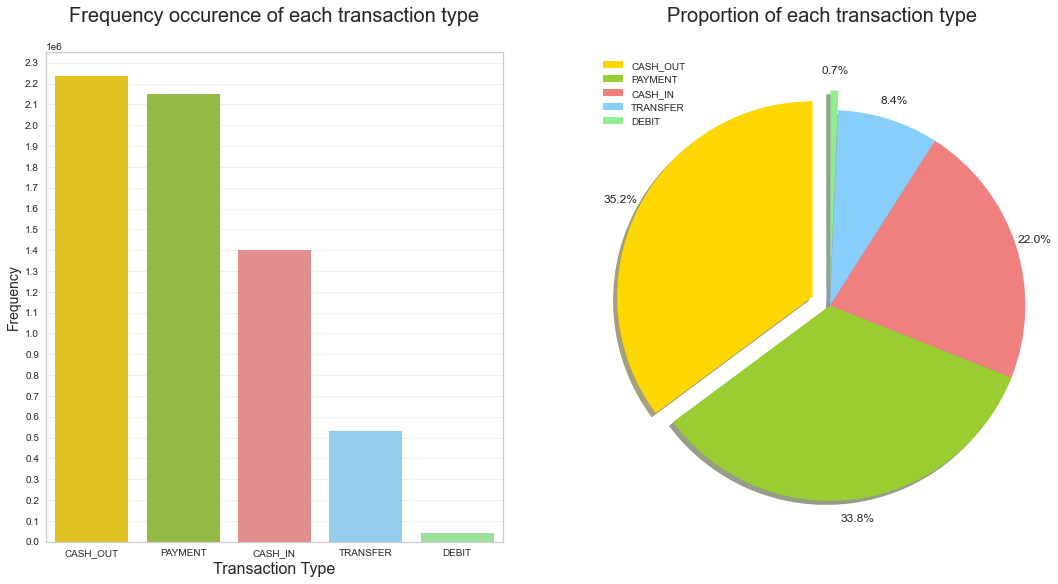

In [15]:
color_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
figure = plt.figure(figsize = [18, 9])
plt.subplot(1,2,1)
plt.grid(axis='y', alpha = 0.3)
sns.barplot(x = data.trans_type.value_counts().index, y = data.trans_type.value_counts(), palette = color_list)
plt.yticks(range(0, 2400000, 100000))
plt.xlabel('Transaction Type', size = 16)
plt.ylabel('Frequency', size = 14)
plt.title('Frequency occurence of each transaction type', y=1.05, size = 20)

plt.subplot(1,2,2)
plt.pie(data.trans_type.value_counts(), labels = None, autopct = '%1.1f%%', colors = color_list, explode = (0.1,0,0,0,0.1), shadow = True, pctdistance=1.1, startangle=90)
plt.title('Proportion of each transaction type', y=1.05, size = 20)
plt.legend(data.trans_type.value_counts().index,loc = 'upper left', frameon=False)
plt.axis('equal')

plt.show()

**Observation:**

- **cash_out and payment** are the most frequent transactions with **cash_out** being only slightly higher
- **debit** is by far the least frequent making up only around 0.7% of the transactions

**Question 2:** what is the **average transaction value** of each **transaction type**?

In [16]:
trans_amount_frame = pd.DataFrame(data=data[["trans_type", "trans_amount"]].groupby("trans_type").aggregate({"trans_amount":{'mean','sum','count'}}).reset_index())
trans_amount_frame.columns = ["trans type", "total trans amount", "avg trans amount", "# of trans"]
trans_amount_frame.T

,0,1,2,3,4
trans type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
total trans amount,2.36367e+11,3.94413e+11,2.27199e+08,2.80934e+10,4.85292e+11
avg trans amount,1399284,2237500,41432,2151495,532909
# of trans,168920,176274,5483.67,13057.6,910647


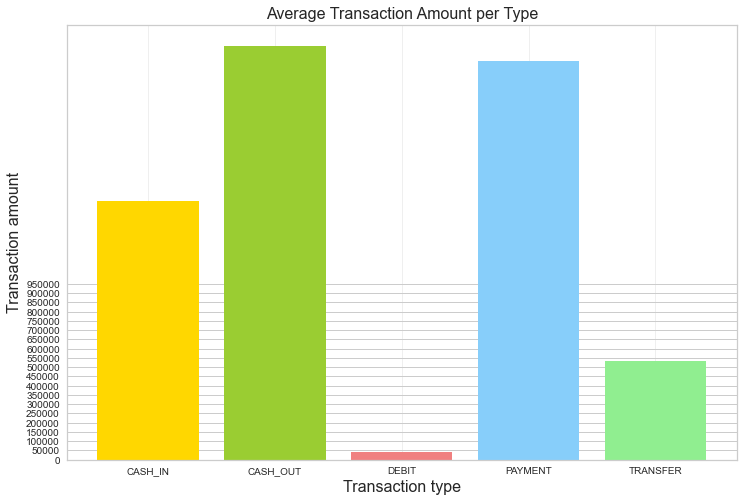

In [17]:
figure = plt.figure(figsize = [12, 8])
plt.bar(trans_amount_frame["trans type"], trans_amount_frame["avg trans amount"], color = color_list)
plt.title("Average Transaction Amount per Type", size = 16)
plt.xlabel("Transaction type", size = 16)
plt.ylabel("Transaction amount", size = 16)
plt.yticks(range(0, 1000000, 50000))
plt.grid(axis = 'x', alpha = 0.3)
plt.show()

**Observation:** 

- **transfer** transactions have the **highest average amount** i.e. **$\$$910647 dollars**.

**Question 3:** What is the **proportion of transactions who are fraud and who are not**?

In [18]:
print("Transactions that are not fraudulent: ", data["check_fraud"].value_counts()[0])
print("Transactions that are fraudulent: ", data["check_fraud"].value_counts()[1])

Transactions that are not fraudulent:  6354407
Transactions that are fraudulent:  8213


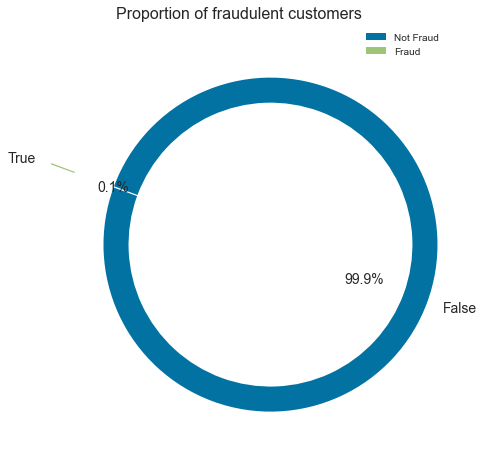

In [19]:
space = np.ones(2)/10
data['check_fraud'].value_counts().plot(kind = 'pie', explode = [0.2,0.2], fontsize = 14, autopct = '%3.1f%%', wedgeprops = dict(width=0.15), 
                                    shadow = False, startangle = 160, figsize = [13.66, 7.68], legend = True)
plt.legend(['Not Fraud', 'Fraud'], frameon=False)
plt.ylabel('')
plt.title('Proportion of fraudulent customers', size = 16)
plt.show()

**Observation:**

- Only **0.1% of transactions are fraudulent (high class imbalance)** with respect to all other transactions.

**Question 4:** What is the **frequency distribution of transactions types** happened **with respect to customer being fraud**

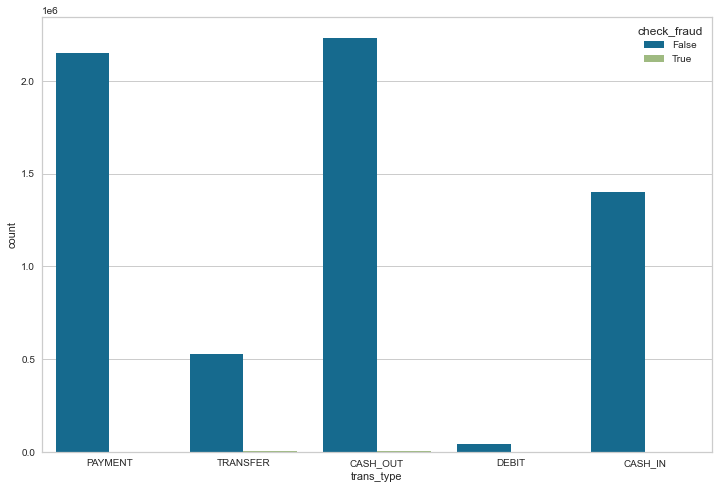

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(data=data, x='trans_type', hue='check_fraud')
plt.show()

**Question 5:** What is the **minimumn & maximum transaction amount identified as fraudulent** transaction?**

In [21]:
min_amount = data.loc[data['check_fraud'] == 1]['trans_amount'].min()
max_amount = data.loc[data['check_fraud'] == 1]['trans_amount'].max()
print('Minimum amount transacted as fraudulent =', min_amount)
print('Maximum amount transacted as fraudulent =', max_amount)

Minimum amount transacted as fraudulent = 0.0
Maximum amount transacted as fraudulent = 10000000.0


**Observation:**

- minimum fraudulent transaction amount = \$0
- maximum fraudulent transaction amount = \$10 million

**Question 6:** What is the **minimumn & maximum transaction amount identified as non-fraudulent** transaction?

In [22]:
min_amount = data.loc[data['check_fraud'] == 0]['trans_amount'].min()
max_amount = data.loc[data['check_fraud'] == 0]['trans_amount'].max()
print('Minimum amount transacted fails to identify as fraudulent =', min_amount)
print('Maximum amount transacted fails to identify as fraudulent =', max_amount)

Minimum amount transacted fails to identify as fraudulent = 0.01
Maximum amount transacted fails to identify as fraudulent = 92445516.64


**Observation:**

- minimum fraudulent transaction amount = \$0.01
- maximum fraudulent transaction amount = \$92445516.64

### Most of the fraudulent transaction happened in the transfer and cash_out type of transactions

**Analysing transfer transactions**

In [23]:
data_transfer = data[data['trans_type'] == 'TRANSFER']
data_flagged = data[data['check_fraud'] == 1]
data_notflagged = data[data['check_fraud'] == 0]
print('TRANSFER Data Shape:', data_transfer.shape)
print('Flagged data Shape:', data_flagged.shape)
print('Not Flagged data Shape:', data_notflagged.shape)
data_transfer.head()

TRANSFER Data Shape: (532909, 10)
Flagged data Shape: (8213, 10)
Not Flagged data Shape: (6354407, 10)


,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,True
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,False
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,False
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,False
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,False


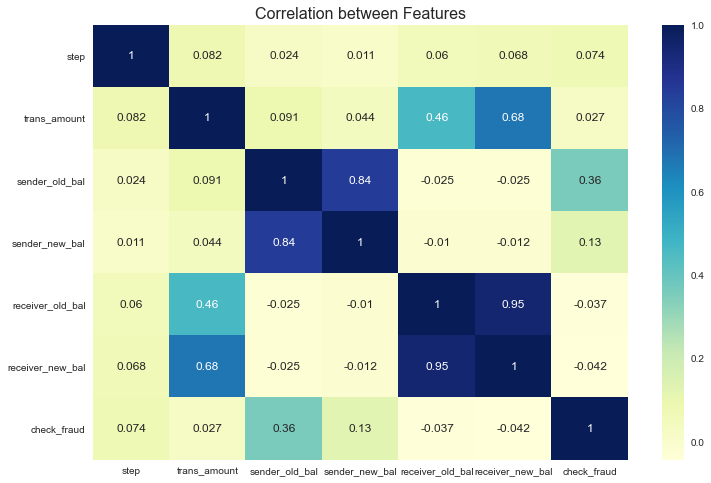

In [24]:
figure = plt.figure(figsize = [12, 8])
sns.heatmap(data = data_transfer.corr(), annot = True, cmap = 'YlGnBu')
plt.title('Correlation between Features', size = 16)
plt.show()

**Observation:**

* **trans_amount** and **receiver_new_bal** feature seems to be **moderately** **correlated**.
* **sender_old_bal** and **sender_new_bal** feature seems to be **highly** **correlated**.
* **receiver_old_bal** and **receiver_new_bal** feature seems to be **highly** **correlated** as well.

**Question 7:** How much **money** has been **laundered at different amounts of chunks**?

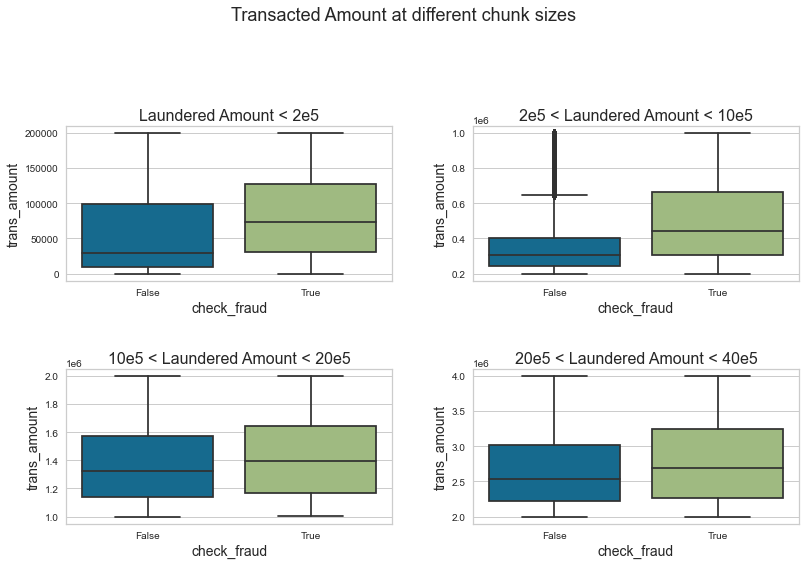

In [25]:
figure = plt.figure(figsize = [12, 8])
plt.subplot(2, 2, 1)
sns.boxplot(x = 'check_fraud', y = 'trans_amount', data = data[data['trans_amount'] < 2e5])
plt.xlabel('check_fraud', size = 14)
plt.ylabel('trans_amount', size = 14)
plt.title('Laundered Amount < 2e5', size = 16)

plt.subplot(2, 2, 2)
sns.boxplot(x = 'check_fraud', y = 'trans_amount', data = data[(data['trans_amount'] > 2e5) & (data['trans_amount'] < 10e5)])
plt.xlabel('check_fraud', size = 14)
plt.ylabel('trans_amount', size = 14)
plt.title('2e5 < Laundered Amount < 10e5', size = 16)

plt.subplot(2, 2, 3)
sns.boxplot(x = 'check_fraud', y = 'trans_amount', data = data[(data['trans_amount'] > 10e5) & (data['trans_amount'] < 20e5)])
plt.xlabel('check_fraud', size = 14)
plt.ylabel('trans_amount', size = 14)
plt.title('10e5 < Laundered Amount < 20e5', size = 16)

plt.subplot(2, 2, 4)
sns.boxplot(x = 'check_fraud', y = 'trans_amount', data = data[(data['trans_amount'] > 20e5) & (data['trans_amount'] < 40e5)])
plt.xlabel('check_fraud', size = 14)
plt.ylabel('trans_amount', size = 14)
plt.title('20e5 < Laundered Amount < 40e5', size = 16)

plt.suptitle('Transacted Amount at different chunk sizes', size = 18, y = 1.02)
plt.tight_layout(pad = 3.0)
plt.show()

**Observation:**

- median fraud transaction amounts are **higher** than the median non-fraudulent transaction amounts. 

**Question 8:** What is the **minimum & maximum amount of sender's old balance with respect to being fraudulent or not**?

In [26]:
print('(check_fraud = 1, Min):', data_transfer[data_transfer['check_fraud'] == 1]['sender_old_bal'].min())
print('(check_fraud = 1, Max):', data_transfer[data_transfer['check_fraud'] == 1]['sender_old_bal'].max())
print('(check_fraud = 0, Min):', data_transfer[data_transfer['check_fraud'] == 0]['sender_old_bal'].min())
print('(check_fraud = 0, Max):', data_transfer[data_transfer['check_fraud'] == 0]['sender_old_bal'].max())

(check_fraud = 1, Min): 0.0
(check_fraud = 1, Max): 59585040.37
(check_fraud = 0, Min): 0.0
(check_fraud = 0, Max): 25908675.06


**Observation:**

- For **Non-Fraudulent**: The **minimum balance** of sender side was **0** while **maximum balance** was **~26 million dollars**.
- For **Fraudulent**: The **minimum balance** of sender side was **0** while **maximum balance** was **~59 million dollars**.

## Customer & Merchant Transactional Analysis

**Question 1: Have** the **receiver side** of transactions been **flagged as fraud inititated by other transactions**?

In [27]:
print(data_flagged['receiver'].isin(data_notflagged['sender_name']).any())
print(data_flagged['receiver'].isin(data_notflagged['sender_name']).sum())

True
18


**Observation**

- There are transaction receivers that have engaged in fraudulent activity

**Question 2:** How many **receiver side of transactions** have been **flagged as fraud more than once**?

In [28]:
total_freq = data_flagged['receiver'].isin(data_notflagged['receiver']).sum()
percent = total_freq/len(data_flagged)
print('Total Transactions:', total_freq)
print('%age:', np.round(percent, decimals=3)*100, '%')

Total Transactions: 5532
%age: 67.4 %


**Observation:**

- Around **67.4%** of flagged **transactions** are in **not flagged** data on the **receiver side** of the transactions.

**Question 3:** Are there any **merchants among sender** accounts **for CASH_IN transactions**?

In [29]:
print(data[data['trans_type'] == 'CASH_IN']['sender_name'].str.contains('M').any())

False


**Observation:**

- It turns out that **there aren't any** transactions with **merchant** with **CASH_IN** type on **sender** side.

**Question 4:** Are there **any merchants among the sender & receiver accounts for each type of transaction** ?

In [30]:
print()
print('CASH_IN')
print('Sender: ', data[data['trans_type'] == 'CASH_IN']['sender_name'].str.contains('M').any())
print('Receiver: ', data[data['trans_type'] == 'CASH_IN']['receiver'].str.contains('M').any())
print()
print('CASH_OUT')
print('Sender: ', data[data['trans_type'] == 'CASH_OUT']['sender_name'].str.contains('M').any())
print('Receiver: ',data[data['trans_type'] == 'CASH_OUT']['receiver'].str.contains('M').any())
print()
print('DEBIT')
print('Sender: ', data[data['trans_type'] == 'DEBIT']['sender_name'].str.contains('M').any())
print('Receiver: ',data[data['trans_type'] == 'DEBIT']['receiver'].str.contains('M').any())
print()
print('TRANSFER')
print('Sender: ', data[data['trans_type'] == 'TRANSFER']['sender_name'].str.contains('M').any())
print('Receiver: ',data[data['trans_type'] == 'TRANSFER']['receiver'].str.contains('M').any())
print()
print('PAYMENT')
print('Sender: ', data[data['trans_type'] == 'PAYMENT']['sender_name'].str.contains('M').any())
print('Receiver: ',data[data['trans_type'] == 'PAYMENT']['receiver'].str.contains('M').any())


CASH_IN
Sender:  False
Receiver:  False

CASH_OUT
Sender:  False
Receiver:  False

DEBIT
Sender:  False
Receiver:  False

TRANSFER
Sender:  False
Receiver:  False

PAYMENT
Sender:  False
Receiver:  True


**Observation:**

- There are **no merchants present among sender & receiver** accounts for each type of transactions. 
- Merchants are **only present in destination** accounts for all **PAYMENTS**.

**Question 5:** Is there **any merchant present in the receiver account except the PAYMENT type**?

In [31]:
print((data[data['receiver'].str.contains('M')]["trans_type"]!='PAYMENT').any())

False


In [32]:
print('Fraudulent CASH_OUT')
print('Sender side: ', data[(data['trans_type'] == 'CASH_OUT') & data['check_fraud'] == 1]['sender_name'].str.contains('M').any())
print('Receiver side: ', data[(data['trans_type'] == 'CASH_OUT') & data['check_fraud'] == 1]['receiver'].str.contains('M').any())
print()
print('Non-fraudulent CASH_OUT')
print('Sender side: ', data[(data['trans_type'] == 'CASH_OUT') & data['check_fraud'] == 0]['sender_name'].str.contains('M').any())
print('Receiver side: ', data[(data['trans_type'] == 'CASH_OUT') & data['check_fraud'] == 0]['receiver'].str.contains('M').any())

Fraudulent CASH_OUT
Sender side:  False
Receiver side:  False

Non-fraudulent CASH_OUT
Sender side:  False
Receiver side:  True


**Observation:**

- For all the transactions **among the labelled account** names **in Sender** and **Receiver**, the **merchant, transaction doesn't show any relationship**.
- From the data, it could be easily visualized that **fraud is commited by TRANSFER and CASH_OUT type of transactions**. 
- **CASH_OUT is done by transacting with a merchant who pays out cash**.
- The **fraudulent account would be both**, the **receiver in a TRANSFER** and the **sender in a CASH_OUT**. 

In [33]:
data[(data['trans_type'] == 'TRANSFER') & data['check_fraud'] == 1].head()

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.0,True
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.0,True
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.0,True
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,True
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,True


In [34]:
data[(data['trans_type'] == 'CASH_OUT') & data['check_fraud'] == 1].head()

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,True
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,True
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,True
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,True
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,True


In [35]:
data_trans_fraud = data[(data["trans_type"] == 'TRANSFER') & (data["check_fraud"] == 1)]
data_cashout_fraud = data[(data["trans_type"] == 'CASH_OUT') & (data["check_fraud"] == 1)]
print(data_trans_fraud['receiver'].isin(data_cashout_fraud["sender_name"]).any())

False


**Observation:**

- It turns out that **there aren't any transactions** that receiver of TRANSFER is present in the sender of the CASH_OUT type.

**Question 7:** Were there **any accounts in receiver side** of **TRANSFER type** transactions which were **originator for CASH_OUT** type transactions **that were genuine** & unable to detect **at begining but later were found fraudulent**?

<center><img src = "https://raw.githubusercontent.com/insaid2018/Domain_Case_Studies/master/Finance/Question/question%206.8.png"></center>

In [36]:
notFraud = data[data["check_fraud"]==0]
isFraud = data[data["check_fraud"]==1]
data_trans_fraud[data_trans_fraud["receiver"].isin(notFraud[notFraud["trans_type"] == 'CASH_OUT']['sender_name'])]

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,True
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,True
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,True


**Observation:**

- It turns out there are **3 such transactions**. 
- However, **2 out of 3 of these accounts first make a genuine CASH_OUT and later receives a fraudulent TRANSFER**. 
- **Thus, fraudulent transactions are not indicated by the sender_name and receiver features.**

In [37]:
isFraud[(isFraud['trans_type'] == 'CASH_OUT') & (isFraud['sender_name'] == 'C1714931087')]

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud


In [38]:
notFraud[(notFraud['trans_type'] == 'CASH_OUT') & (notFraud['sender_name'] == 'C1714931087')]

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
6149940,546,CASH_OUT,18091.05,C1714931087,197227.0,179135.95,C1339132632,66177.84,84268.89,False


**Observation for [1030443]:**
- No fraudulent cash_out transactions were marked for this customer before step 65.

- The first transaction cash_out transaction after step of 65, happened at step 546.

In [39]:
notFraud[(notFraud['trans_type'] == 'CASH_OUT') & (notFraud['sender_name'] == 'C423543548')]

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
2186261,185,CASH_OUT,214555.85,C423543548,0.0,0.0,C1066927674,4575179.83,4789735.69,False


In [40]:
notFraud[(notFraud['trans_type'] == 'CASH_OUT') & (notFraud['sender_name'] == 'C1023330867')]

,step,trans_type,trans_amount,sender_name,sender_old_bal,sender_new_bal,receiver,receiver_old_bal,receiver_new_bal,check_fraud
1168398,132,CASH_OUT,29084.28,C1023330867,51999.0,22914.72,C1422447255,0.0,29084.28,False


**Observation for [6039814 & 6362556]:**

- **Fraudulent** **TRANSFER to C423543548** occurred **at step = 486** whereas genuine **CASH_OUT from this account occurred earlier at step = 185**
- **Fraudulent TRANSFER to C1023330867 occurred at step = 738** whereas genuine **CASH_OUT** **from this account occurred earlier at step = 132**

## Post Data Processing & Analysis

- Frauds occur only in transfer and cash_out type of transactions
- The present goal is to select only those rows corresponsing to those types of transactions as well as to remove the sender_name and receiver columns (since they are not relevant for the following analysis)

In [41]:
data_1=data[(data["trans_type"] == 'TRANSFER') | (data["trans_type"] == 'CASH_OUT')].drop(['sender_name','receiver'],axis=1)
print(data_1.shape)
data_1.head()

(2770409, 8)


,step,trans_type,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,check_fraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,True
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,True
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,False
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,False
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,False


In [42]:
dataFraud = data_1[data_1['check_fraud'] == 1]
dataNotFraud = data_1[data_1['check_fraud'] == 0]
print(dataFraud.shape)
print(dataNotFraud.shape)

(8213, 8)
(2762196, 8)


Several rows have 0 balance in the sender's account before and after non-zero transactions

In [43]:
value1 = len(dataFraud[(dataFraud['sender_old_bal'] == 0) & (dataFraud['sender_new_bal'] == 0) & (dataFraud['trans_amount'] > 0)])/len(dataFraud)
value2 = len(dataNotFraud[(dataNotFraud['sender_old_bal'] == 0) & (dataNotFraud['sender_new_bal'] == 0) & (dataNotFraud['trans_amount'] > 0)])/len(dataNotFraud)

print("fraction of fraudulent transactions having zero sender_old_bal sender_new_bal after a non-zero transaction: ",np.round(value1,4))
print("fraction of non-fraudulent transactions having zero sender_old_bal sender_new_bal after a non-zero transaction: ",np.round(value2,4))

fraction of fraudulent transactions having zero sender_old_bal sender_new_bal after a non-zero transaction:  0.003
fraction of non-fraudulent transactions having zero sender_old_bal sender_new_bal after a non-zero transaction:  0.4737


**Observations**

- **Non-fraudulent data:**
    - **~47%** of data has zero sender_old_bal and sender_new_bal
    - Given that this class is over-represented, the overal model should not suffer from dropping these rows after replacing the 0s with null
 
- **Fraudulent data:**
    - **~0.3%** of the data has zero sender_old_bal and sender_new_bal
    - The fraction is very small and can be dropped as null values

In [44]:
# Replacing 0s with NaN values
data_1.loc[(data_1['sender_old_bal'] == 0) & (data_1['sender_new_bal'] == 0) & (data_1['trans_amount'] != 0), ['sender_old_bal', 'sender_new_bal']] = np.nan

Repeating the same for the receiver columns

In [45]:
value3 = len(dataFraud[(dataFraud['receiver_old_bal'] == 0) & (dataFraud['receiver_new_bal'] == 0) & (dataFraud['trans_amount'] > 0)])/len(dataFraud)
value4 = len(dataNotFraud[(dataNotFraud['receiver_old_bal'] == 0) & (dataNotFraud['receiver_new_bal'] == 0) & (dataNotFraud['trans_amount'] > 0)])/len(dataNotFraud)

print("fraction of fraudulent transactions having zero receiver_old_bal receiver_new_bal after a non-zero transaction: ",np.round(value3,4))
print("fraction of non-fraudulent transactions having zero receiver_old_bal receiver_new_bal after a non-zero transaction: ",np.round(value4,4))

fraction of fraudulent transactions having zero receiver_old_bal receiver_new_bal after a non-zero transaction:  0.4956
fraction of non-fraudulent transactions having zero receiver_old_bal receiver_new_bal after a non-zero transaction:  0.0006


**Obervations:**

- Unlike the previous case, the number of zeroes is much higher in the fraudulent cases **(~50%)** than non-fraudulent ones **(0.6%)**.
- Therefore, receiver account balance being zero is a strong predictor of fraud and it i a good idea to distinguish this for the ML algorithm

In [46]:
# Replacing 0s with -1 for fraud identification by machine
data_1.loc[(data_1['receiver_old_bal'] == 0) & (data_1['receiver_new_bal'] == 0) & (data_1['trans_amount'] != 0), ['receiver_old_bal', 'receiver_new_bal']] = - 1

### Identifying and Handling NaN valued transactions

In [47]:
null_frame = pd.DataFrame(data_1.isnull().sum(), columns = ['Frequency'])
null_frame.transpose()

,step,trans_type,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,check_fraud
Frequency,0,0,0,1308566,1308566,0,0,0


### Dropping all rows containing NaN values on sender_old_bal and sender_new_bal features.

In [48]:
print('Old Data Shape:', data_1.shape)
data_1.dropna(axis = 0, inplace = True)
print('New Data Shape: ', data_1.shape)
null_frame = pd.DataFrame(data_1.isnull().sum(), columns = ['Frequency'])
null_frame.transpose()

Old Data Shape: (2770409, 8)
New Data Shape:  (1461843, 8)


,step,trans_type,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,check_fraud
Frequency,0,0,0,0,0,0,0,0


### Feature Extraction

In [49]:
# creating 2 new features

data_1['errorBalanceSender'] = data_1['sender_new_bal'] + data_1['trans_amount'] - data_1['sender_old_bal']
data_1['errorBalanceReceiver'] = data_1['receiver_old_bal'] + data_1['trans_amount'] - data_1['receiver_new_bal']
print('New Data Shape:', data_1.shape)
data_1.head()

New Data Shape: (1461843, 10)


,step,trans_type,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,check_fraud,errorBalanceSender,errorBalanceReceiver
2,1,TRANSFER,181.00,181.0,0.0,-1.0,-1.00,True,0.00,181.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,True,0.00,21363.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,False,213808.94,182703.5
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,False,214605.30,237735.3
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,False,300850.89,-2401220.0


## Post Profile Report

profile = ProfileReport(df=data_1, minimal=True)
profile.to_file("PostProfilingReport.html")

<AxesSubplot:>

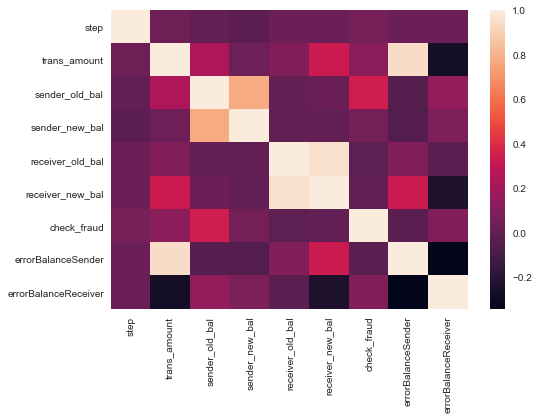

In [50]:
sns.heatmap(data_1.corr())

**Observation:**

- **trans_amount** is **highly** **skewed**.
- **receiver_old_bal contains** around **13.8% of zeros**.
- **errorBalanceSender contains** around **9% of zeros**.
- **errorBalanceReceiver contains** around **57.9% of zeros**.
- **sender_new_bal** is **highly correlated** with **sender_old_bal** (not high importance).
- **receiver_new_bal** is **highly correlated** with **receiver_old_bal** (not high importance).

## Data splitting

In [51]:
X = data_1.drop("check_fraud",axis = 1)
y = data_1["check_fraud"]

print('X Shape:', X.shape)
print('y Shape:', y.shape)

X.loc[X["trans_type"]=="TRANSFER","trans_type"] = 0
X.loc[X["trans_type"]=="CASH_OUT","trans_type"] = 1
X.trans_type = X.trans_type.astype('int')

X Shape: (1461843, 9)
y Shape: (1461843,)


In [52]:
X.head()

,step,trans_type,trans_amount,sender_old_bal,sender_new_bal,receiver_old_bal,receiver_new_bal,errorBalanceSender,errorBalanceReceiver
2,1,0,181.00,181.0,0.0,-1.0,-1.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


## Feature Analysis

In [53]:
def plotStrip(x, y, hue, ylabel, title):
  '''
  A function to analyze pattern for frauduent and non-fraudulent data.
  x : Target feature
  y : Numerical feature
  hue: Categorical feature
  ylabel: ylabel of graph
  title: Title of graph
  '''
  fig = plt.figure(figsize = [13.66, 7.68])
  with sns.axes_style('ticks'):
    ax = sns.stripplot(x, y, hue = hue, jitter = 0.4, marker = '.', size = 4, palette = ["#E8000B", '#56D3DB'])
    ax.set_xlabel('')
    ax.set_ylabel(ylabel, size = 14)
    ax.set_title(title, size = 16)
    ax.set_xticklabels(['Genuine', 'Fraudulent'], size = 14)
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ['TRANSFER', 'CASH_OUT'], bbox_to_anchor = (1, 1), loc = 2, borderaxespad = 0, fontsize = 16)
  return ax

**Pattern 1:** with respect to steps

C:\Users\anirv\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


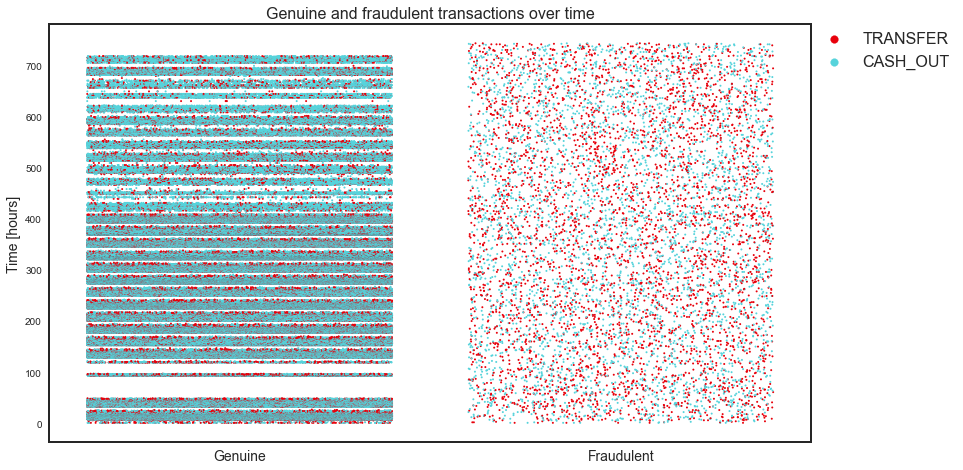

In [54]:
limit = len(X)
X_data = y[:limit]
Y_data = X['step'][:limit]
HUE = X['trans_type'][:limit]
YLABEL = 'Time [hours]'
TITLE = 'Genuine and fraudulent transactions over time'

plotStrip(x = X_data, y = Y_data, hue = HUE, ylabel = YLABEL, title = TITLE)
plt.show()

**Observation:**

- For **Genuine transactions**, **TRANSFER type** of transactions have **occured less than the CASH_OUT**.

- For **Fraudulent transactions** there is **no distinct pattern** with respect to step.

**Pattern 2:** with respect to transacted amount

C:\Users\anirv\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


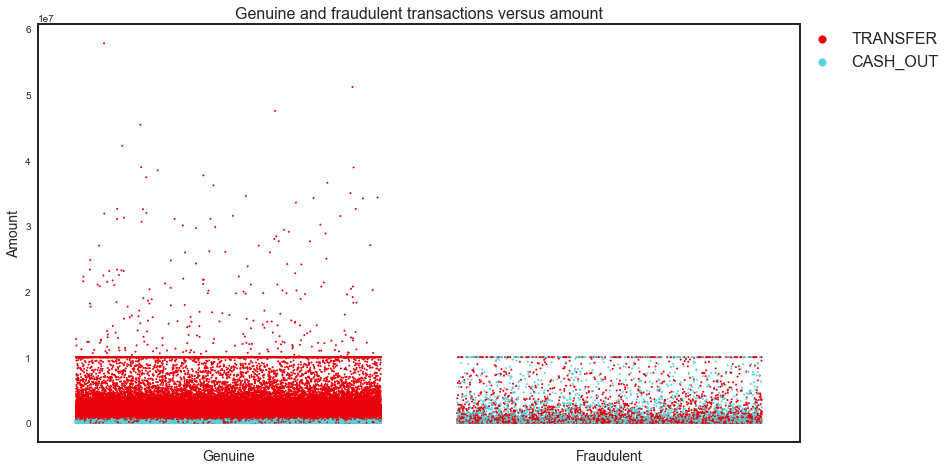

In [55]:
limit = len(X)
X_data = y[:limit]
Y_data = X['trans_amount'][:limit]
HUE = X['trans_type'][:limit]
YLABEL = 'Amount'
TITLE = 'Genuine and fraudulent transactions versus amount'

plotStrip(x = X_data, y = Y_data, hue = HUE, ylabel = YLABEL, title = TITLE)
plt.show()

**Observation:**

- A clear boundary appears at **10 million for both genuine and fraudulent transactions**.

- **After 10 million** dollars **there is random spread** of data **for genuine TRANSFER type**.

- **Genuine TRANSFER type** transactions have happened **more than genuine CASH_OUT** transactions.

- **Genuine TRANSFER** transactions **around the 10 million amount is more frequent**.

- For **fraudulent transactions random spread is observed for both** TRANSFER & CASH_OUT type transactions.

**Pattern 3:** with respect to error in receiver account

C:\Users\anirv\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


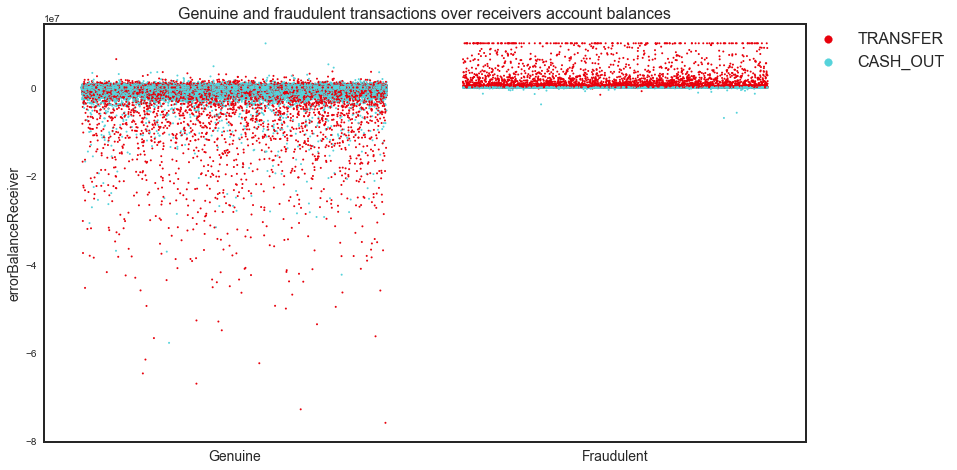

In [56]:
limit = len(X)
X_data = y[:limit]
Y_data = X['errorBalanceReceiver'][:limit]
HUE = X['trans_type'][:limit]
YLABEL = 'errorBalanceReceiver'
TITLE = 'Genuine and fraudulent transactions over receivers account balances'

plotStrip(x = X_data, y = Y_data, hue = HUE, ylabel = YLABEL, title = TITLE)
plt.show()

## Correlation between Fraudulent and Non-Fraudulent Data

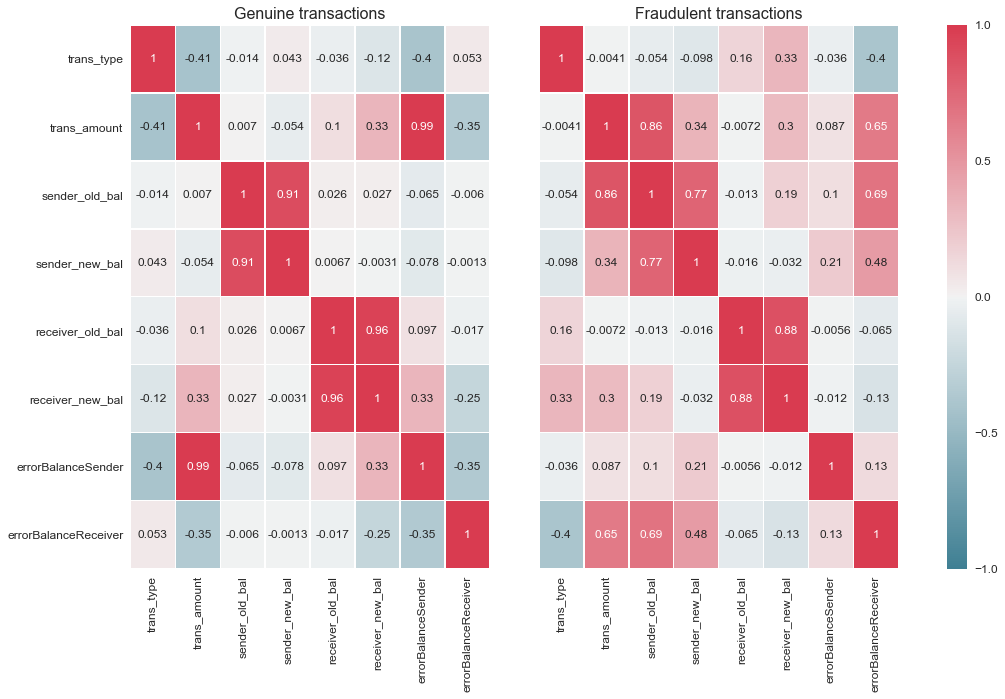

In [57]:
Xfraud = X.loc[y == 1] 
XnonFraud = X.loc[y == 0]

correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw = grid_kws, figsize = [15, 10])
cmap = sns.diverging_palette(220, 8, as_cmap=True)
                             
ax1 = sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, cbar = False, annot = True)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 12)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 12)
ax1.set_title('Genuine transactions', size = 16)

ax2 = sns.heatmap(correlationFraud, ax = ax2, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, annot = True, 
                  yticklabels = False,  cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical',  'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 12) 
ax2.set_title('Fraudulent transactions', size = 16)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 12)
plt.show()

**Observation:**

- Genuine Data:
 - **trans_amount** is **highly correlated** with **errorBalanceSender**.

 - **sender_old_bal** is **highly correlated** with **sender_new_bal**.

 - **receiver_old_bal** is **highly correlated** with **receiver_new_bal**.

- Fraudulent Data:
 - **trans_amount** is **highly correlated** with **sender_old_bal**.

 - **sender_old_bal** is **moderately correlated** with **sender_new_bal**.

 - **receiver_old_bal** is **moderately correlated** with **receiver_new_bal**.
 
 - **errorBalanceReceiver** is **moderately correalted** with **sender_old_bal and trans_amount**.

## Model Development and Evaluation

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print('Training Data Shape:', X_train.shape, y_train.shape)
print('Testing Data Shape:', X_test.shape, y_test.shape)

Training Data Shape: (1169474, 9) (1169474,)
Testing Data Shape: (292369, 9) (292369,)


Given that the data is highly imbalanced w.r.t the fraudulent class, oversampling (using SMOTE) is a good idea. But baseline tests should also be conducted to see the effect of oversampling.

In [59]:
def PRCurve(model):
  '''
  A function to compute Precision Recall Curve
  Data to fit must be training i.e. X_train, y_train
  Data score will be estimated on X_test, y_test
  '''
  viz = PrecisionRecallCurve(model)
  viz.fit(X_train, y_train)
  avg_prec = viz.score(X_test, y_test)
  plt.legend(labels = ['Binary PR Curve',"AP=%.3f"%avg_prec], loc = 'lower right', prop={'size': 14})
  plt.xlabel(xlabel = 'Recall', size = 14)
  plt.ylabel(ylabel = 'Precision', size = 14)
  plt.title(label = 'Precision Recall Curve', size = 16)

## Baseline Models

### Logistic Regression

Accuracy Score (Train Data): 0.994
Accuracy Score (Test Data): 0.994
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       0.48      0.41      0.44      1638

    accuracy                           0.99    292369
   macro avg       0.74      0.70      0.72    292369
weighted avg       0.99      0.99      0.99    292369



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


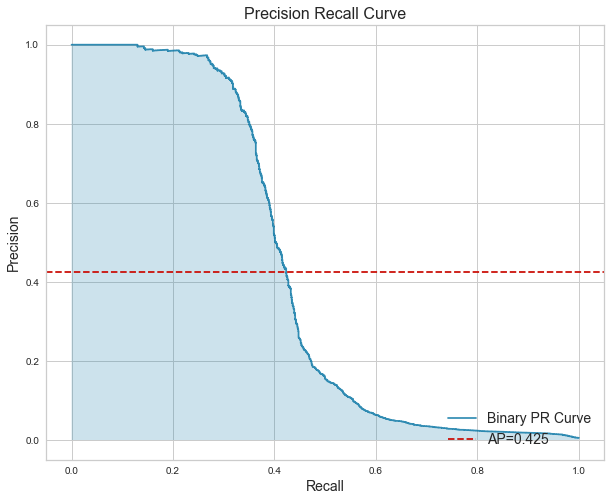

In [60]:
log  = LogisticRegression(random_state = 42)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print('Accuracy Score (Train Data):', np.round(log.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(log.score(X_test, y_test), decimals = 3))

base_logistic_report = classification_report(y_test, y_pred)
print(base_logistic_report)

plt.figure(figsize = [10, 8])
PRCurve(model = log)
plt.show()

**Observation:**

- **Model accuracy = 99%** because the **data is imbalanced**. 
- The model is **biased towards the majority class**.
- The **average precision score is not satisfactory**.

### Decision Tree Classifier

Accuracy Score (Train Data): 0.998
Accuracy Score (Test Data): 0.998
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       0.99      0.67      0.80      1638

    accuracy                           1.00    292369
   macro avg       1.00      0.84      0.90    292369
weighted avg       1.00      1.00      1.00    292369



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


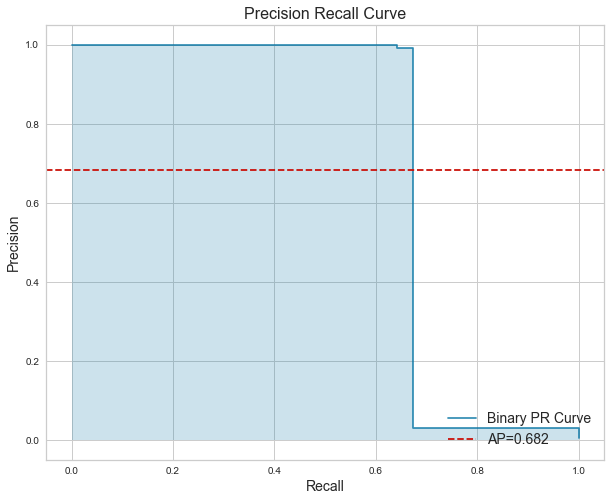

In [61]:
dtc = DecisionTreeClassifier(random_state = 42, max_depth = 5)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print('Accuracy Score (Train Data):', np.round(dtc.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(dtc.score(X_test, y_test), decimals = 3))

base_decision_tree_report = classification_report(y_test, y_pred)
print(base_decision_tree_report)

plt.figure(figsize = [10, 8])
PRCurve(model = dtc)
plt.show()

**Observation:**

- **No significant change in accuracy**.
- **Precision, Recall has improved** but **not by much**.
- The **average precision** has also **improved to 68%**.

### Random Forest Classifier

Accuracy Score (Train Data): 0.998
Accuracy Score (Test Data): 0.998
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       1.00      0.67      0.80      1638

    accuracy                           1.00    292369
   macro avg       1.00      0.84      0.90    292369
weighted avg       1.00      1.00      1.00    292369



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


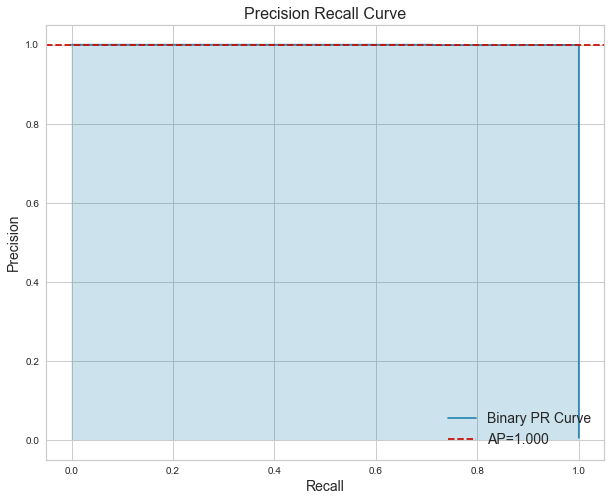

In [62]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 42, n_jobs = -1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Accuracy Score (Train Data):', np.round(rfc.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(rfc.score(X_test, y_test), decimals = 3))

base_random_forest_report = classification_report(y_test, y_pred)
print(base_random_forest_report)

plt.figure(figsize = [10, 8])
PRCurve(model = rfc)
plt.show()

**Observation:**

- **Precision for minority class has improved** but the **recall is still low**.
- **F1 score** for **minority class** has also **improved** but still not good.
- **Average precision** has **imporoved significantly** to **100%**.

### XGBoost Classifier

Accuracy Score (Train Data): 1.0
Accuracy Score (Test Data): 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       1.00      1.00      1.00      1638

    accuracy                           1.00    292369
   macro avg       1.00      1.00      1.00    292369
weighted avg       1.00      1.00      1.00    292369



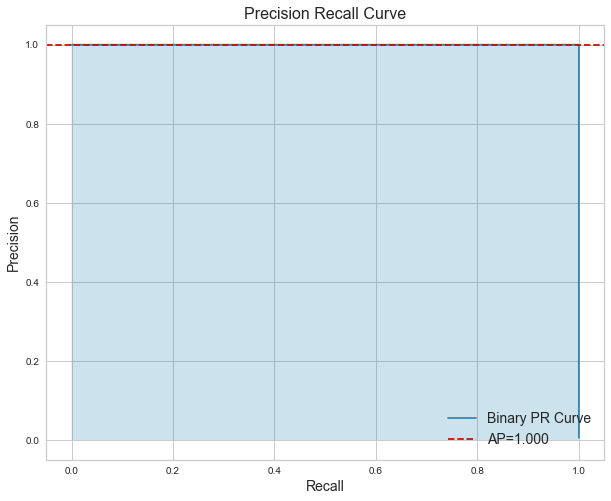

In [63]:
base_clf = XGBClassifier(max_depth = 5, n_jobs = -1, random_state = 42)
base_clf.fit(X_train, y_train)
y_pred = base_clf.predict(X_test)

print('Accuracy Score (Train Data):', np.round(base_clf.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(base_clf.score(X_test, y_test), decimals = 3))

base_XGB_report = classification_report(y_test, y_pred)
print(base_XGB_report)

plt.figure(figsize = [10, 8])
PRCurve(model = base_clf)
plt.show()

**Observation:**

- All metrics have improved significantly
- **Precision, Recall and F1 score have improved to ~100%**.

## Oversampling Models

**Before implementing SMOTE**

In [64]:
print('Training Data Shape:', X_train.shape, y_train.shape)
print('Testing Data Shape:', X_test.shape, y_test.shape)

Training Data Shape: (1169474, 9) (1169474,)
Testing Data Shape: (292369, 9) (292369,)


**Performing SMOTE**

In [65]:
sm = SMOTE(random_state = 42, sampling_strategy = 1.0)
X1, y1 = sm.fit_resample(X, y)

X_new = pd.DataFrame(data = X1, columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_new, y1, test_size = 0.2, random_state = 42, stratify = y1)

**After implementing SMOTE**

In [66]:
print('Training Data Shape:', X_train.shape, y_train.shape)
print('Testing Data Shape:', X_test.shape, y_test.shape)

Training Data Shape: (2325848, 9) (2325848,)
Testing Data Shape: (581462, 9) (581462,)


### Logistic Regression

Accuracy Score (Train Data): 0.921
Accuracy Score (Test Data): 0.921
              precision    recall  f1-score   support

       False       0.97      0.87      0.92    290731
        True       0.88      0.97      0.92    290731

    accuracy                           0.92    581462
   macro avg       0.93      0.92      0.92    581462
weighted avg       0.93      0.92      0.92    581462



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


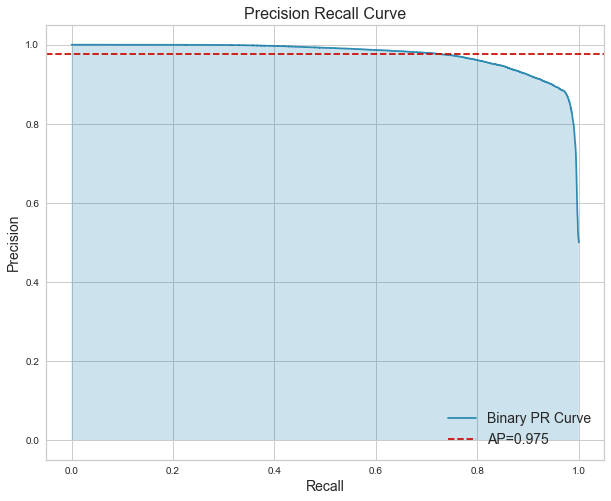

In [67]:
log  = LogisticRegression(random_state = 42)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

print('Accuracy Score (Train Data):', np.round(log.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(log.score(X_test, y_test), decimals = 3))

oversample_logistic_report = classification_report(y_test, y_pred)
print(oversample_logistic_report)

plt.figure(figsize = [10, 8])
PRCurve(model = log)
plt.show()

**Observation:**

- Much better precision and recall scores than the baseline model, but the accuracy is lesser

### Decision Tree classifier

Accuracy Score (Train Data): 1.0
Accuracy Score (Test Data): 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       0.99      0.67      0.80      1638

    accuracy                           1.00    292369
   macro avg       1.00      0.84      0.90    292369
weighted avg       1.00      1.00      1.00    292369



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


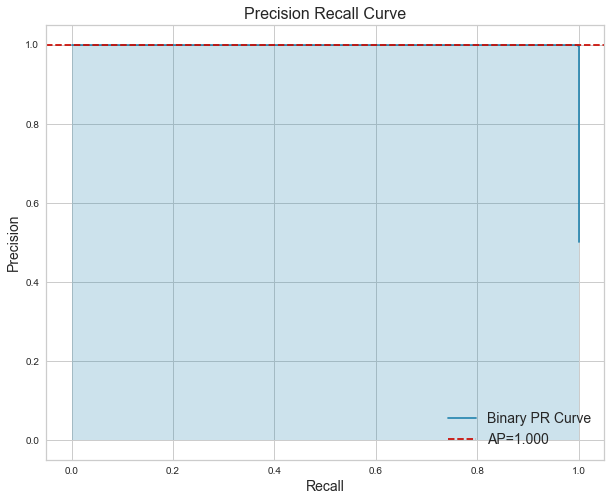

In [68]:
dtc = DecisionTreeClassifier(random_state = 42, max_depth = 5)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print('Accuracy Score (Train Data):', np.round(dtc.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(dtc.score(X_test, y_test), decimals = 3))

oversample_decision_tree_report = classification_report(y_test, y_pred)
print(base_decision_tree_report)

plt.figure(figsize = [10, 8])
PRCurve(model = dtc)
plt.show()

**Observation::**

- Precision, Recall and accuracy have achieved 100% scores

### Random Forest classifier

Accuracy Score (Train Data): 1.0
Accuracy Score (Test Data): 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       1.00      1.00      1.00    290731

    accuracy                           1.00    581462
   macro avg       1.00      1.00      1.00    581462
weighted avg       1.00      1.00      1.00    581462



C:\Users\anirv\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


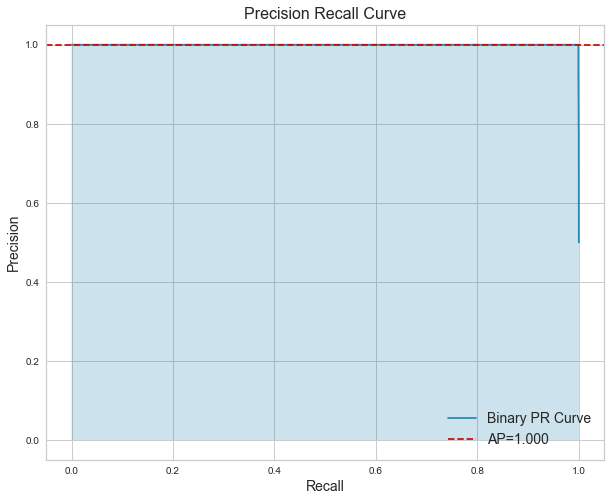

In [69]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 42, n_jobs = -1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Accuracy Score (Train Data):', np.round(rfc.score(X_train, y_train), decimals = 3))
print('Accuracy Score (Test Data):', np.round(rfc.score(X_test, y_test), decimals = 3))

oversample_random_forest_report = classification_report(y_test, y_pred)
print(oversample_random_forest_report)

plt.figure(figsize = [10, 8])
PRCurve(model = rfc)
plt.show()

## Model Comparison

In [70]:
print("Logistic regression")
print()
print(base_logistic_report)
print("Decision Tree classification")
print()
print(base_decision_tree_report)
print("Random Forest classifier")
print()
print(base_random_forest_report)
print("XGBoost")
print()
print(base_XGB_report)

Logistic regression

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       0.48      0.41      0.44      1638

    accuracy                           0.99    292369
   macro avg       0.74      0.70      0.72    292369
weighted avg       0.99      0.99      0.99    292369

Decision Tree classification

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       0.99      0.67      0.80      1638

    accuracy                           1.00    292369
   macro avg       1.00      0.84      0.90    292369
weighted avg       1.00      1.00      1.00    292369

Random Forest classifier

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    290731
        True       1.00      0.67      0.80      1638

    accuracy                           1.00    292369
   macro avg       1.00      0.84      0.90    2923

**XGBoost shows the best performance among the base models. This can be used to better understand the most important columns.**

## Feature Importances

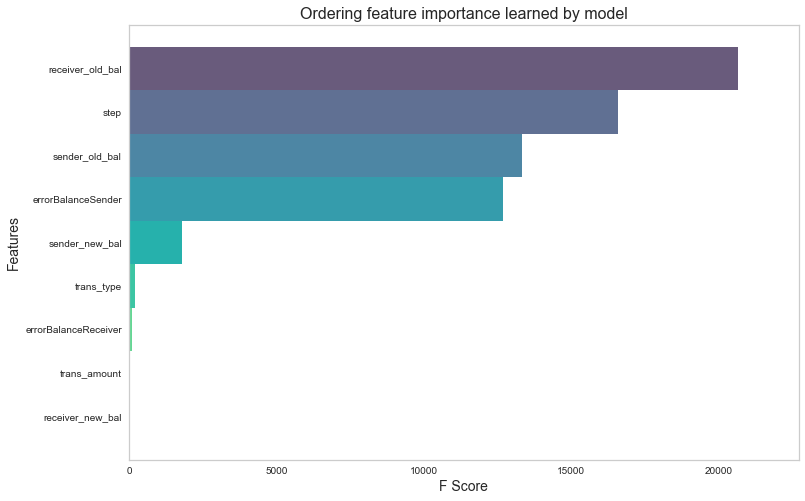

In [71]:
fig = plt.figure(figsize = [12, 8])
ax = fig.add_subplot(1, 1, 1)
colours = ['#CAF270', '#95E681', '#65D794', '#3CC5A3', '#26B1AC', '#359CAC', '#4D86A4', '#607093', '#695B7C']
ax = plot_importance(base_clf, height = 1, color = colours, grid = False, show_values = False, importance_type = 'cover', ax = ax)
ax.set_xlabel(xlabel = 'F Score', size = 14)
ax.set_ylabel(ylabel = 'Features', size = 14)
plt.title('Ordering feature importance learned by model', size = 16)
plt.show()

**Observation:**

- **receiver_old_bal, sender_old_bal, step, errorBalanceSender, sender_new_bal and trans_type** are the features categorized as **important** by **XGBoost model**.